# Вычисление значения кусочно линейной функции одной переменной

Решением задачи линейного программирования мы можем получить значения кусочно-линейных функций.

Нам потребуется линейные решатели, numpy и графика:

In [1]:
pip install cylp 


The following command must be run outside of the IPython shell:

    $ pip install cylp 

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
pip install --upgrade pip 


The following command must be run outside of the IPython shell:

    $ pip install --upgrade pip 

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [41]:
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


## Прямая задача

Рассмотрим кусочно-линейную функцию такого вида, чтобы она принимала нулевое значение для $x <= 0$ и выпуклой для $x > 0$. Функция заданна на $n$ точках из отрезка $[a,b]$.

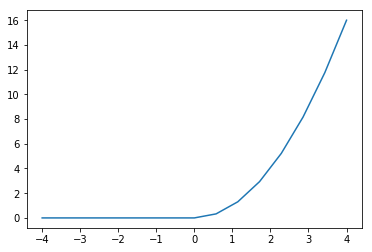

In [4]:
n = 15
a, b = -4, 4
x = np.linspace(a,b,n)
y = np.piecewise(x, [x <= 0, x > 0], 
                [0, lambda x: x**2])
plt.plot(x,y)

Мы будем искать значение $y_0$ для некоторого заданного $x_0$

In [5]:
x_0 = 2

Поиск координаты $y$ при заданных $x$ можно свести к решению следующей задачи ЛП:

$$
\min_{u_i, i=1,\ldots,n} y = \sum_{i=1}^{n} u_i y_i,
$$

при условиях:

$$
\sum_{i=1}^{n} u_i x_i = x_0,\\
\sum_{i=1}^{n} u_i = 1, \\
u_i >= 0, i = 1,\ldots, n.
$$

Для этого сформируем матрицу коэффициентов $A$ для представления ограчничений в матричной форме и вектор $b$:

In [6]:
A = np.vstack([x,np.ones(n)])
A = np.matrix(A)
b = CyLPArray(np.array([x_0, 1]))

После всего этого мы можем спокойно отправить в *cylp* нашу матрицу и решить задачу:

In [7]:
s = CyClpSimplex()
u = s.addVariable('u',n)

s += A*u == b

for i in range(n):
    s += u[i] >= 0

s.optimizationDirection = 'min'
s.objectiveCoefficients = y
s.primal()

'optimal'

Значением функции будет величина скалярного произведения набора оптимизируемых параметров, на соответсвующие точки в таблице значений кусочно-линейной функции

In [8]:
cond = s.primalVariableSolution['u']
x_res = np.dot(cond, x)
y_res = np.dot(cond, y)

print(x_0,x_res)
print(x_0**2, y_res)

2 2.0
4 4.0816326530612255


Выделим в отдельную функцию, процесс, который описан выше: 

In [9]:
def plpp(xs,ys,x_0):
    x,y = xs,ys
    s = CyClpSimplex()
    u = s.addVariable('u',n)

    A = np.vstack([x,np.ones(n)])
    A = np.matrix(A)
    b = CyLPArray(np.array([x_0, 1]))
    
    s += A*u == b

    for i in range(n):
        s += u[i] >= 0
        
    s.optimizationDirection = 'min'
    s.objectiveCoefficients = y
    s.primal()
    cond = s.primalVariableSolution['u']
    y_res = np.dot(cond, y)
    
    return y_res

Теперь можем вычислять значения функции в любой точке заданной области на основании линейной интерполляции табличных значений.

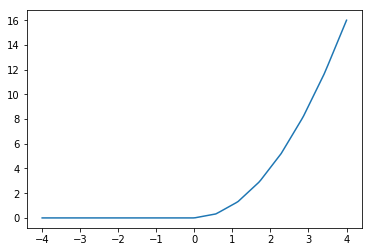

In [10]:
a,b = -4,4
n_res = n*10
x_res = np.linspace(a,b,n_res)
y_res = np.empty(n_res)

for i in range(n_res):
    y_res[i] = plpp(x,y,x_res[i])

plt.plot(x_res, y_res)

Для проверки вычислим величину отклонения приближения, крестиком обозначим те точки, на которых заданно табличное значение:

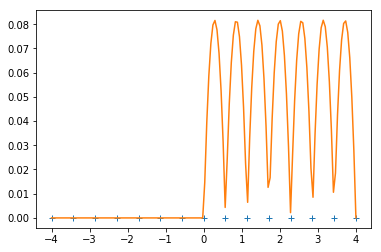

In [11]:
y_test = np.piecewise(x_res, [x_res <= 0, x_res > 0], 
                [0, lambda x: x**2])
plt.plot(x,np.zeros_like(x),'+')
plt.plot(x_res, abs(y_test - y_res))

## Двойственная задача

## Прямая и двойственная задача

# Вычисление значения кусочно линейной функции двух переменных

Мы попытаемся вычислить функцию двух переменных $y = xz$ на области $x \in [0,1], z \in [0,1]$ при условии, что $x + z < 1$.

In [12]:
x = np.arange(0.1, 1, 0.1, dtype=np.double)
z = np.arange(0.1, 1, 0.1, dtype=np.double)
x,z = np.meshgrid(x, z)
y = 1/(x * z)

x = x.flatten()
z = z.flatten()
y = y.flatten()

mask = x+z <= 1

x = x[mask]
z = z[mask]
y = y[mask]


## Прямая задача

In [13]:
def plpp2d(xs,zs,ys,x_0,z_0):
    x,z,y = xs,zs,ys
    dim_p = len(x)
    rhs_p = np.array([x_0,z_0, 1], dtype=np.double)
    dim_d = len(rhs_p) 
    
    s = CyClpSimplex()
    u = s.addVariable('u',dim_p)



    A_p = np.vstack([x,
                     z,
                     np.ones(dim_p)])
    
    A_p = np.matrix(A_p)
    b_p = CyLPArray(rhs_p)
    
    s += A_p*u == b_p

    for i in range(n):
        s += u[i] >= 0
        
    s.optimizationDirection = 'min'
    s.objectiveCoefficients = y
    s.primal()
    cond = s.primalVariableSolution['u']
    y_res = np.dot(cond, y)
    
    return s.objectiveValue

In [14]:
plpp2d(x,z,y,0.5,0.5)

4.0

## Двойственная задача

In [15]:
def plpd2d(xs,zs,ys,x_0,z_0):
    x,z,y = xs,zs,ys
    dim_p = len(x)
    rhs_p = np.array([x_0,z_0, 1], dtype=np.double)
    dim_d = len(rhs_p)

    A_d = np.hstack([x.reshape(-1, 1),
                     z.reshape(-1, 1),
                     np.ones(len(x)).reshape(-1, 1)])
    A_d = np.matrix(A_d)

    s = CyClpSimplex()

    l = s.addVariable('l', dim_d)

    b_d = CyLPArray(y)

    s += A_d * l <= b_d


    s.optimizationDirection = 'max'
    s.objectiveCoefficients = rhs_p

    s.primal()
    
    return s.objectiveValue


In [16]:
plpd2d(x,z,y,0.5,0.5)

4.0

## Прямая и двойственная задача

In [34]:
def plppd2d(xs,zs,ys,x_0,z_0):
    x,z,y = xs,zs,ys
    dim_p = len(x)
    rhs_p = np.array([x_0,z_0, 1], dtype=np.double)
    dim_d = len(rhs_p) 
    
    s = CyClpSimplex()
    u = s.addVariable('u', dim_p)
    l = s.addVariable('l', dim_d)


    A_p = np.vstack([y,
                     x,
                     z,
                     np.ones(dim_p)])
    
    A_p = np.matrix(A_p)
    b_p = CyLPArray(np.hstack([0,rhs_p]))
    
    A_d = np.hstack([x.reshape(-1, 1),
                     z.reshape(-1, 1),
                     np.ones(len(x)).reshape(-1, 1)])
    A_d = np.matrix(A_d)
    b_d = CyLPArray(y)
    
    A_d1 = np.matrix(np.vstack([-rhs_p,np.zeros((3,3))]))
    
    s += A_p*u + A_d1*l  == b_p

    s += A_d*l <= b_d
    
    for i in range(dim_p):
        s += u[i] >= 0
        
    s.optimizationDirection = 'max'
    s.objective = u[0]
    s.primal()
    cond = s.primalVariableSolution['u']
    y_res = np.dot(cond, y)
    
    return y_res
plppd2d(x,z,y,0.5,0.5)

4.000000000000002

Проверим, полученнуй метод. Попытаемся расчитать функцию $y=xz$. При этом, важно понимать, что метод работает только на выпуклых (вогнутых) функциях. А функция $y = xz$ таковой не является. Однако на некоторых областях выпуклость можно обеспечить через попытку найти значение обратной функции $y = \frac{1}{xz}$. Что и делает текущий метод

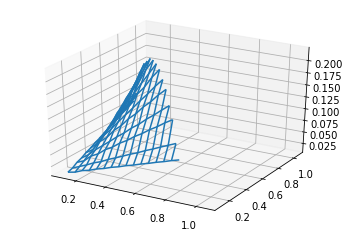

In [90]:
xa, xb = 0.1, 1.1
za, zb = 0.1, 1.1
step = 0.1
test_step = 0.05
x = np.arange(xa, xb, step, dtype=np.double)
z = np.arange(za, zb, step, dtype=np.double)
x,z = np.meshgrid(x, z)
y = 1/(x * z)

x = x.flatten()
z = z.flatten()
y = y.flatten()

mask = x+z <= 1

x = x[mask]
z = z[mask]
y = y[mask]

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = [plppd2d(x,z,y,x0,z0) for x0,z0 in zip(xs,zs)]
ys = np.array(ys)
ys = 1/ys

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xs, zs, yy)


[3.46944695e-18 1.66666667e-03 1.38777878e-17 1.00000000e-03
 6.93889390e-18 7.14285714e-04 2.77555756e-17 5.55555556e-04
 2.77555756e-17 4.54545455e-04 8.32667268e-17 3.84615385e-04
 0.00000000e+00 3.33333333e-04 4.16333634e-17 2.94117647e-04
 1.66666667e-03 2.50000000e-03 3.33333333e-03 3.21428571e-03
 5.00000000e-03 4.50000000e-03 5.45454545e-03 5.96153846e-03
 6.42857143e-03 7.50000000e-03 7.64705882e-03 8.61111111e-03
 9.00000000e-03 9.64285714e-03 1.04347826e-02 0.00000000e+00
 3.33333333e-03 3.46944695e-17 2.00000000e-03 1.38777878e-17
 1.42857143e-03 4.16333634e-17 1.11111111e-03 8.32667268e-17
 9.09090909e-04 0.00000000e+00 7.69230769e-04 1.38777878e-16
 6.66666667e-04 1.00000000e-03 3.21428571e-03 2.00000000e-03
 2.50000000e-03 3.00000000e-03 2.79411765e-03 4.00000000e-03
 3.40909091e-03 5.00000000e-03 4.16666667e-03 5.17241379e-03
 5.00000000e-03 5.58823529e-03 1.04083409e-17 5.00000000e-03
 2.77555756e-17 3.00000000e-03 2.77555756e-17 2.14285714e-03
 2.22044605e-16 1.666666

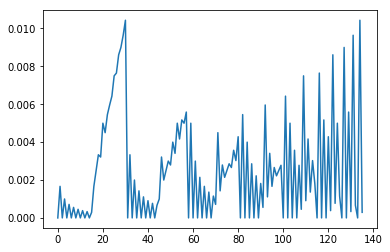

In [91]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
print(d)
plt.plot(d)